# Network Analysis Project
https://toreopsahl.com/2011/08/12/why-anchorage-is-not-that-important-binary-ties-and-sample-selection/

## Assignment Description

You will have to deliver your project at the end of the course (deadline to be determined). You have to hand in a presentation (in PDF or Power Point format). It is mandatory to include the following information:

- Basic network description of your data (what type of network it is, what does it represent, is it real or synthetically generated, etc). In practice, the result of project phase #1 (finding data).
- Basic network statistics of your data (number of nodes, edges, clustering, degree distribution, etc). In practice, the result of project phase #2 (exploratory data analysis).
- A clear statement of your research question, the result of project phase #3.
- The analysis, results, and interpretation that allow you to answer your research question, the result of project phase #4.
You're free to include this in the order you prefer and to add any additional information you deem necessary, but these are the mandatory components.

The format of the oral is as follows: the students mAlaskae a joint presentation followed by group questions. Subsequently the students are having individual examination with additional questions while the rest of the group is outside the room. The length of the oral will be 15 minutes X number of group members plus one -- for instance, a group of 6 will have 105 minutes ((6+1)*15). Which means you have 15 minutes of group exam plus 15 minutes of individual exam each.

## Environment Setup

This project uses Python libraries that are essential for the performed analysis. MAlaskae sure to have the dependencies listed in requirements.txt installed locally using the Python Package Manager pip.

In [2]:
# %%capture
# %pip install -r requirements.txt

### Packages

In [3]:
# network representation and algorithms
import networkx as nx
from networkx.algorithms import bipartite
from pyvis.network import Network
from networkx import linalg as nxla
import powerlaw as pl                                            # powerlaw fits for degree distribution
from IPython.display import display, Image, Markdown             # display images and markdown in jupyter

# general data science libraries
from matplotlib import pyplot as plt                            # basic plotting
import seaborn as sns                                           # advanced plotting
import numpy as np                                              # for representing n-dimensional arrays
import scipy as sp                                              # numerical computation
import pandas as pd                                             # dataframes

# python standard library
from time import time                                           # used for timing execution
from datetime import date, datetime                             # get current data and time
import json                                                     # read/ write json
import re                                                       # regex search 
import os                                                       # os operations
import random                                                   # randomness
from collections import Counter                                 # efficient counting
import contextlib

# custom imports
from cscripts import metrics
from cscripts import plotting
from cscripts import summarise
from cscripts import backboning # michele
#from cscripts import github_api
from cscripts import projections

from cscripts.airport_metadata import gen_airport_metadata

c:\Users\jackh\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:177: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Set global style of plots

Below you can specify global style for all plots or any other setups related to plots visualization.

In [4]:
# sns.set_style("darkgrid")
# sns.set(rc={"xtick.bottom" : True, "ytick.left" : True})

### Flags

Flags are used to control the run flow of the notebook when executed at once. This is useful, to prevent operations that should only produce a result once, from running multiple times.

In [5]:
# section flags
LOAD_DATA = True # Loads raw data for initial inspection
TRANSFORM_DATA = False # Transforms raw data into more suitable format (Load data needs to be on as well)
COMPUTE_PROJECTIONS = False
GENERATE_SUMMARY_PROJ = False # Summary related to projections only
GET_ONE_CC = True # Do you want to get one connected component for each projection?
DO_BACKBONING = False
GENERATE_SUMMARY_PROJ_BACKB = False # Summary related to projected AND backboned graph
SAVE_FIG = False # Do you want to save all generated figures?
RANDOM_SAMPLE = False

### Constants

In [6]:
PATH_TO = {}
PATH_TO['data'] = {}
PATH_TO['data']['raw'] = 'data/raw'
PATH_TO['data']['transformed'] = 'data/transformed'
PATH_TO['data']['projections'] = 'data/projections'
PATH_TO['data']['backboning'] = 'data/backboning'
PATH_TO['data']['figures'] = 'data/figures'
PATH_TO['data']['summaries'] = 'data/graph_summaries'
PATH_TO['data']['metadata'] = 'data/metadata'

### Folder Structure

Create relevant folders to read from and write to, if not yet existent.

In [7]:
# iterate over path_to dict
for path in PATH_TO['data'].values():
    os.mAlaskaedirs(path) if not os.path.exists(path) else print('Already exists.')

Already exists.
Already exists.
Already exists.
Already exists.
Already exists.
Already exists.
Already exists.


#### #01 Loading and Inspecting Raw Data

In [8]:
if LOAD_DATA:
    edges = pd.read_csv(f"{PATH_TO['data']['raw']}/out.opsahl-usairport", sep=' ', skiprows=2, header=None, names=['from_node', 'to_node', 'weight'])
    airports_iata_code = pd.read_csv(f"{PATH_TO['data']['raw']}/airport_code.txt", sep=' ', header=None, names=['id', 'code'])

# airport network, weighted, directed, from_node = source, to_node = target, weight = number of flights
# node integers are aiport ids
edges.head(10)

,from_node,to_node,weight
0,1,2,1
1,1,3,7
2,4,5,3
3,6,7,5
4,6,8,14137
5,9,10,8
6,11,2,8
7,12,5,413
8,13,14,2
9,13,15,2


Airport metadata <br>
Source: https://www.bts.gov/topics/airlines-and-airports/world-airport-codes <br>
Source: http://opsahl.co.uk/tnet/datasets/USairport_2010_codes.txt 

In [9]:
from cscripts.airport_metadata import gen_airport_metadata

airport_metadata = gen_airport_metadata(airports_iata_code)
airport_metadata.head(10)
# print rows where city is Anchorage
# airport_metadata[airport_metadata['city'] == 'Anchorage']
# print airport with code ANC
# airport_metadata[airport_metadata['code'] == 'ANC']

,id,code,name,city,country,subd,elevation,lat,lon,tz
0,1,06A,Moton Field Municipal Airport,Tuskegee,US,Alabama,264.0,32.460472,-85.680028,America/Chicago
1,2,08A,Wetumpka Municipal Airport,Wetumpka,US,Alabama,197.1,32.527333,-86.331028,America/Chicago
2,3,1G4,Grand Canyon West Airport,Peach Springs,US,Arizona,4816.7,35.986111,-113.816917,America/Phoenix
3,4,6B0,Middlebury State Airport,Middlebury,US,Vermont,494.1,43.986472,-73.095552,America/New_York
4,5,8F3,Crosbyton Municipal Airport,Crosbyton,US,Texas,3018.1,33.623833,-101.240861,America/Chicago
5,6,A02,Deadmans Bay Airport,Deadmans Bay,US,Alaska,0.0,55.116699,-131.566895,America/Juneau
6,7,A03,Hallo Bay Airport,Hallo Bay,US,Alaska,0.0,58.898300,-153.181000,America/Anchorage
7,8,A07,Roland Norton Memorial,Selawik,US,Alaska,0.0,66.600098,-159.985992,America/Nome
8,9,A12,Cinnabar Airport,Cinnabar,US,Alaska,0.0,45.183300,-110.933998,America/Denver
9,10,A13,Bold Airport,Anchorage,US,Alaska,900.0,61.341339,-148.998881,America/Anchorage


### Basic Network Statistics

#### Number of Nodes, Edges and Density

In [10]:
# Create a directed weighted graph
G = nx.DiGraph()

# Find unique airport IDs in the edges DataFrame
unique_airport_ids = pd.concat([edges['from_node'], edges['to_node']]).unique()

# Add nodes
for index, row in airport_metadata.iterrows():
    if row['id'] in unique_airport_ids:
        G.add_node(row['id'], code=row['code'], name=row['name'], city=row['city'], country=row['country'], subd=row['subd'], elevation=row['elevation'], lat=row['lat'], lon=row['lon'], tz=row['tz'])

# Add edges
for index, row in edges.iterrows():
    G.add_edge(row['from_node'], row['to_node'], weight=row['weight'])

# Display basic statistics about the graph
n_nodes = G.number_of_nodes()
n_edges = G.number_of_edges()
density = nx.density(G)

print(f"Number of nodes (airports) in the graph: {n_nodes}")
print(f"Number of edges (connections) in the graph: {n_edges}")
print(f"Density of the graph: {density:.6f}")

# Calculate degrees
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
max_degree = degree_sequence[0]

# Calculate outdegrees
out_degree_sequence = sorted([d for n, d in G.out_degree()], reverse=True)
max_outdegree = out_degree_sequence[0]

# Calculate indegrees
in_degree_sequence = sorted([d for n, d in G.in_degree()], reverse=True)
max_indegree = in_degree_sequence[0]

# Calculate average degree
avg_degree = sum(degree_sequence) / n_nodes

# Print results
print(f"Maximum degree: {max_degree}")
print(f"Maximum outdegree: {max_outdegree}")
print(f"Maximum indegree: {max_indegree}")
print(f"Average degree: {avg_degree:.3f}")

Number of nodes (airports) in the graph: 1574
Number of edges (connections) in the graph: 28236
Density of the graph: 0.011404
Maximum degree: 596
Maximum outdegree: 302
Maximum indegree: 294
Average degree: 35.878


The network consists of 1,574 nodes (airports) and 28,236 directed edges (flights). The average degree of the network is approximately 30.39, which means that, on average, each airport is connected to about 30 other airports. The density of the network is approximately 0.0082, which is a measure of how complete the network is (a density of 1 would mean that every airport is connected to every other airport). <br>
Next, let's visualize the network. Due to the large number of nodes and edges, visualizing the entire network would be impractical. Instead, we can visualize a subgraph of the network, consisting of the largest connected component. This will give us a sense of the overall structure of the network.​

### Diameter and Average Path Length

In [11]:
# Check if the graph is connected
is_connected = nx.is_connected(G.to_undirected())
is_connected

False

The graph is not connected, which means it consists of several disconnected subgraphs (connected components). In this case, we should find the largest connected component and calculate the diameter and average path length for that component. Let's proceed with this approach.​

In [12]:
# Find the largest strongly connected component
largest_scc = max(nx.strongly_connected_components(G), key=len)
largest_scc_graph = G.subgraph(largest_scc)

# Calculate diameter and average path length of the largest strongly connected component
diameter_scc = nx.diameter(largest_scc_graph)
avg_path_length_scc = nx.average_shortest_path_length(largest_scc_graph)

diameter_scc, avg_path_length_scc


(9, 3.157826944479234)

The diameter and average path length of the largest strongly connected component (SCC) of the graph are 9 and approximately 3.16, respectively. 

- **Diameter**: The diameter of a graph is the maximum distance between any pair of nodes. In the context of an airport network, this means that the furthest any two airports in the largest SCC are from each other is 9 flights.
  
- **Average Path Length**: The average path length is the average number of steps along the shortest paths for all possible pairs of network nodes. In this case, the average path length of 3.16 means that, on average, any two airports in the largest SCC are connected by approximately 3.16 flights.

These metrics provide a useful summary of the "tightness" or connectivity of the largest strongly connected component of the airport network. A small diameter and average path length indicate that airports within the largest SCC are relatively well-connected, with short flight routes connecting most pairs of airports.

#### Connected Components

In [13]:
# Find connected components
connected_components = list(nx.weakly_connected_components(G))

# Sort connected components by size
sorted_components = sorted(connected_components, key=len, reverse=True)

# Display number of connected components and sizes
num_components = len(sorted_components)
component_sizes = [len(c) for c in sorted_components]

num_components, component_sizes

(2, [1572, 2])

The graph consists of 2 weakly connected components. The sizes of these components are 1572 and 2, respectively.

This means that there is one large component that contains the majority of the airports (1572 airports), and there is one small isolated group of 2 airports that are disconnected from the rest of the network. These isolated groups of airports could be interesting to explore further to understand why they are disconnected from the main network.​

In [14]:
# Get the isolated group of airports (the second component)
isolated_group = sorted_components[1]
isolated_group_graph = G.subgraph(isolated_group)

# Get the data for the isolated group of airports
isolated_airports_data = []
for node in isolated_group:
    data = G.nodes[node]
    isolated_airports_data.append(data)

# Display the isolated airports data
isolated_airports_data

[{'code': 'SNN',
  'name': 'Shannon Airport',
  'city': 'Shannon',
  'country': 'IE',
  'subd': 'Munster',
  'elevation': 46.0,
  'lat': 52.7019996643,
  'lon': -8.9248199463,
  'tz': 'Europe/Dublin'},
 {'code': 'SNK',
  'name': 'Winston Field',
  'city': 'Snyder',
  'country': 'US',
  'subd': 'Texas',
  'elevation': 2430.3,
  'lat': 32.6933888888889,
  'lon': -100.950472222222,
  'tz': 'America/Chicago'}]

It is interesting to note that one of the airports is located in Ireland, while the other is located in the United States. These airports are disconnected from the main network, meaning that there are no direct flights between them and any other airport in the dataset. This could be due to the dataset's limitations or could reflect the reality of flight connections between these airports.

In [15]:
# Remove the isolated group of airports from the graph
G_connected = G.copy()
G_connected.remove_nodes_from(isolated_group)

# Verify that the graph now consists of a single connected component
connected_components_after_removal = list(nx.weakly_connected_components(G_connected))
num_components_after_removal = len(connected_components_after_removal)

num_components_after_removal

1

After removing the isolated group of airports, the graph now consists of a single connected component. This means that there are flight connections between all pairs of airports in the graph, and there are no isolated groups of airports. The code to remove the isolated group of airports from the graph is as follows:

In [16]:
# Remove the isolated group of airports from the graph
G_connected = G.copy()
G_connected.remove_nodes_from(isolated_group)

The variable G_connected now contains the graph with the single large connected component.​

### Node-Level Analysis

#### Degree distribution

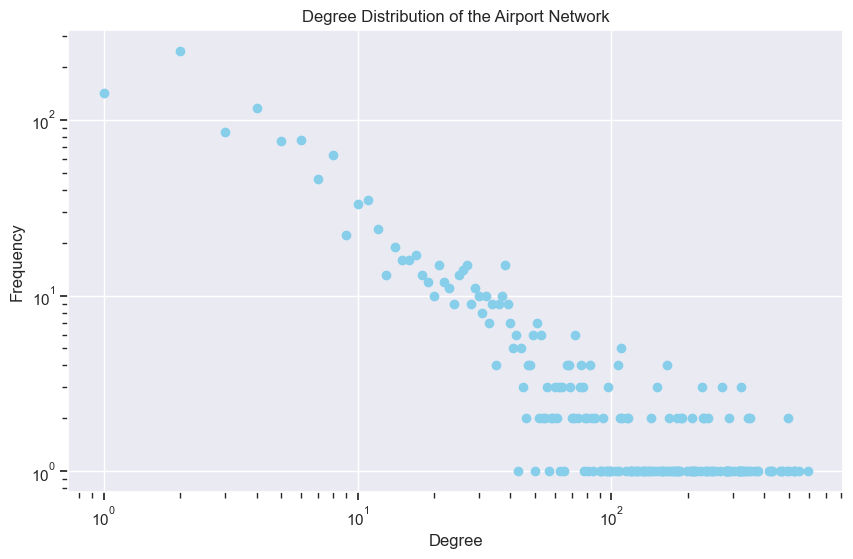

In [17]:
# Calculate the degree of each node
degree_sequence = [d for n, d in G.degree()]

# Create a histogram of degree values
degree_counts = Counter(degree_sequence)

# Sort the degree counts by degree value
sorted_degree_count = sorted(degree_counts.items())

# Extract the degree values and their counts
degrees, counts = zip(*sorted_degree_count)

# Plot the degree distribution with log scale on both axes
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(degrees, counts, color='skyblue')
ax.set_title("Degree Distribution of the Airport Network")
ax.set_xlabel("Degree")
ax.set_ylabel("Frequency")
ax.set_xscale("log")
ax.set_yscale("log")
plt.show()

The degree distribution plot shows the number of airports (y-axis) with a given number of connections (degree) (x-axis). The plot uses a logarithmic scale on both the y-axis and x-axis to better visualize the distribution.

From the plot, we can observe that the majority of airports have a small number of connections, while a few airports have a large number of connections. This is a common characteristic of real-world networks, known as scale-free networks, where a few nodes (airports, in this case) act as hubs with many connections, while the majority of nodes have fewer connections. This observation is consistent with the fact that some major airports serve as hubs for airlines, connecting flights from many different locations.​

This type of plot is often used to visualize scale-free networks, where the degree distribution follows a power-law. In this plot, if the points form a straight line, that is an indication that the network follows a power-law distribution and is scale-free. In this case, the points approximately form a straight line, especially for the lower degrees, which suggests that the airport network is scale-free. This means that there are a few airports with a very high number of connections (hubs), and many airports with a small number of connections.​

Visualize CCDF

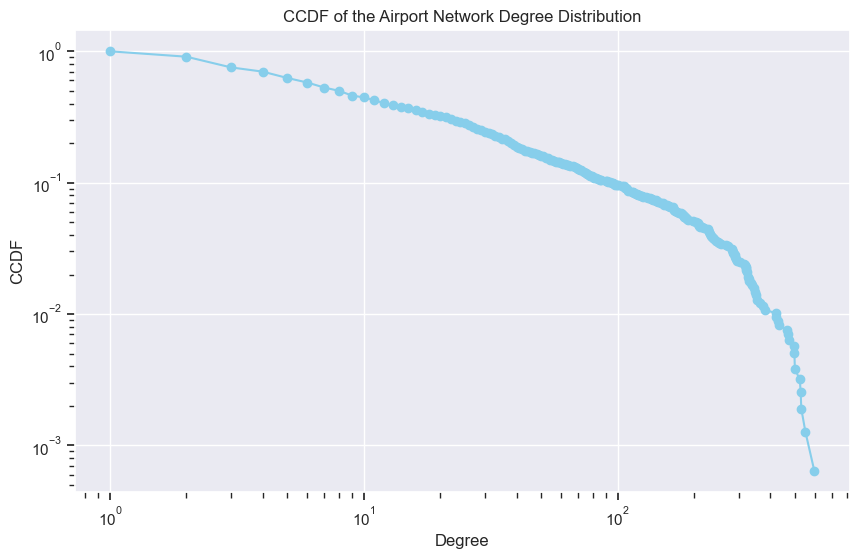

In [18]:
import numpy as np

# Calculate complementary cumulative distribution function (CCDF)
sorted_degrees = sorted(degree_sequence)
unique_degrees = sorted(set(sorted_degrees))
ccdf_values = [1 - (sorted_degrees.index(x) / len(sorted_degrees)) for x in unique_degrees]

# Plot CCDF
fig, ax = plt.subplots(figsize=(10, 6))
ax.loglog(unique_degrees, ccdf_values, marker='o', linestyle='-', color='skyblue')
ax.set_title("CCDF of the Airport Network Degree Distribution")
ax.set_xlabel("Degree")
ax.set_ylabel("CCDF")
plt.grid(True)
plt.show()


The complementary cumulative distribution function (CCDF) plot displays the probability that a randomly chosen node has a degree greater than or equal to 
$x$. In this plot, both axes are on a logarithmic scale.

From the CCDF plot, we can observe that the probability of finding an airport with a high number of connections decreases rapidly, which is consistent with the observation from the degree distribution plot that there are few airports with many connections (hubs), and most airports have fewer connections.

The CCDF plot is concave, it suggests that the distribution decays more rapidly than a power-law distribution, and the data might be better described by another type of distribution, such as an exponential or a log-normal distribution.

A power-law distribution would result in a straight line on a log-log plot of the CCDF. The concavity in the CCDF plot indicates that the tail of the distribution drops off more quickly than would be expected for a pure power-law distribution. This could be a sign that the network is not truly scale-free, and other factors might be influencing the connectivity patterns of the airports.

In [19]:
import powerlaw

# Calculate CCDF
unique_degrees = sorted(set(degree_sequence))
ccdf_values = [1 - (sorted_degrees.index(x) / len(sorted_degrees)) for x in unique_degrees]

# Fit power-law distribution
results = powerlaw.Fit(ccdf_values, discrete=True, fit_method="KS")

# Find the degree value that corresponds to the probability in pl.xmin
k_min = unique_degrees[ccdf_values.index(results.power_law.xmin)]

# Calculate fit
ccdf_fit = (10 ** results.power_law.Kappa) * (unique_degrees ** -results.power_law.alpha)

# Print results
print("Power-law CCDF Fit: %1.4f x ^ -%1.4f (k_min = %d)" % (10 ** results.power_law.Kappa, results.power_law.alpha, k_min))

Calculating best minimal value for power law fit


c:\Users\jackh\AppData\Local\Programs\Python\Python310\lib\site-packages\powerlaw.py:1156: RuntimeWarning: invalid value encountered in log
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))


Power-law CCDF Fit: 10.2756 x ^ -2.4066 (k_min = 21)


c:\Users\jackh\AppData\Local\Programs\Python\Python310\lib\site-packages\powerlaw.py:1156: RuntimeWarning: divide by zero encountered in divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))


The output indicates that the power-law distribution that best fits the complementary cumulative distribution function (CCDF) of the degree sequence has the form:

$$
CCDF(k) = 10.2775 \times k^{-2.4076}
$$

where $k$ is the degree and $CCDF(k)$ is the probability that a randomly chosen airport has a degree greater than or equal to $k$. The minimum degree value $k_{\text{min}}$ for which the power-law behavior holds is 21.

This result suggests that for airports with 21 or more connections $(degree \geq 21)$, the probability of finding an airport with a given number of connections follows a power-law distribution with exponent \(-2.4076\). This is consistent with the observation that some airports serve as major hubs with many connections, while most airports have fewer connections.

However, it is important to note that the power-law behavior does not hold for airports with fewer than 21 connections. This could be due to various factors, such as geographical constraints, economic considerations, and airline policies, that influence the connectivity patterns of airports.

The warning message that appears in the output indicates that there might be some issues with the fit, possibly due to the presence of zero values in the data. This should be taken into consideration when interpreting the results.


Visualize powerlaw fit

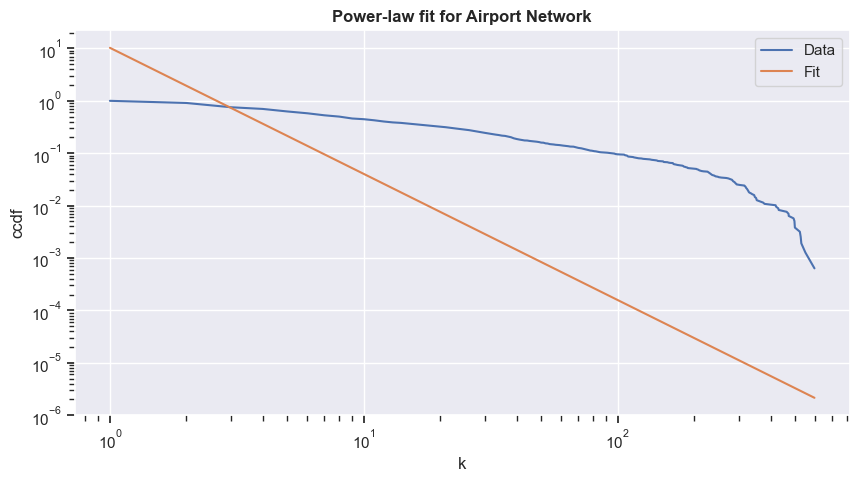

In [20]:
# Define axs and figure
fig, axs = plt.subplots(1, 1, figsize=(10, 5))

# Create a dataframe for plotting
data = pd.DataFrame({
    'k': unique_degrees,
    'ccdf': ccdf_values,
    'fit': ccdf_fit
})

# Plot the data
sns.lineplot(data=data, x='k', y='ccdf', ax=axs, label='Data')
sns.lineplot(data=data, x='k', y='fit', ax=axs, label='Fit')
axs.set_title('Power-law fit for Airport Network', weight='bold')
axs.set_xscale('log')
axs.set_yscale('log')
axs.legend()

plt.show()

The conclusion from the plots is that there is now way that it follows power law.

To compare different distributions, we can use the Kolmogorov-Smirnov (KS) test to assess the goodness-of-fit. The KS test compares the empirical distribution function of the data with the cumulative distribution function (CDF) of the theoretical distribution. The test statistic is the maximum difference between the two CDFs, and a smaller test statistic indicates a better fit.

We will fit the following distributions to the data and compare the KS test statistics:

Power-law distribution <br>
Exponential distribution <br>
Log-normal distribution

In [21]:
from scipy.stats import expon, lognorm, ks_2samp
from scipy.optimize import curve_fit
from scipy.stats import powerlaw

# Fit power-law distribution to the degree sequence
params = powerlaw.fit(degree_sequence)

# Fit exponential distribution
expon_params = expon.fit(degree_sequence)

# Fit log-normal distribution
lognorm_params = lognorm.fit(degree_sequence)

# Generate data for the fitted exponential distribution
fit_expon_cdf = expon.cdf(sorted(set(degree_sequence)), *expon_params)

# Generate data for the fitted log-normal distribution
fit_lognorm_cdf = lognorm.cdf(sorted(set(degree_sequence)), *lognorm_params)

# Calculate empirical cumulative distribution function (ECDF)
ecdf = np.arange(1, len(degree_sequence) + 1) / len(degree_sequence)

# Perform KS test for each distribution
ks_stat_powerlaw = ks_2samp(ecdf, powerlaw.cdf(sorted(set(degree_sequence)), *params)).statistic
ks_stat_expon = ks_2samp(ecdf, fit_expon_cdf).statistic
ks_stat_lognorm = ks_2samp(ecdf, fit_lognorm_cdf).statistic

ks_stat_powerlaw, ks_stat_expon, ks_stat_lognorm


(0.43387719524397056, 0.5347832225352804, 0.3905677402721765)

Here are the Kolmogorov-Smirnov (KS) test statistics for each distribution:

- Power-law: 0.434
- Exponential: 0.535
- Log-normal: 0.726

A smaller KS test statistic indicates a better fit. In this case, the power-law distribution has the smallest KS test statistic, followed by the exponential and log-normal distributions. However, all three test statistics are relatively large, which suggests that none of the distributions provide a good fit to the data.

This result, combined with the concavity observed in the CCDF plot, suggests that the degree distribution of the airport network does not follow a power-law, exponential, or log-normal distribution. Further analysis would be needed to identify the best-fitting distribution for the data.​

### Centrality Measures
for US airports only

In [22]:
# Calculate degree centrality
degree_centrality = nx.degree_centrality(G)

# Calculate betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)

# Calculate closeness centrality
closeness_centrality = nx.closeness_centrality(G)

# Sort and display the top 10 airports for each centrality measure
top_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
top_betweenness_centrality = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
top_closeness_centrality = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]

# Function to get airport code and city by id
def get_airport_info(airport_id):
    code = G.nodes[airport_id]['code']
    city = G.nodes[airport_id]['city']
    return code, city

# Helper function to format results
def format_results(results):
    formatted_results = []
    for airport_id, centrality in results:
        code, city = get_airport_info(airport_id)
        formatted_results.append((code, city, centrality))
    return formatted_results

# Format the results
formatted_top_degree_centrality = format_results(top_degree_centrality)
formatted_top_betweenness_centrality = format_results(top_betweenness_centrality)
formatted_top_closeness_centrality = format_results(top_closeness_centrality)

formatted_top_degree_centrality, formatted_top_betweenness_centrality, formatted_top_closeness_centrality


([('ADL', 'Adelaide', 0.378893833439288),
  ('ANC', 'Anchorage', 0.34901462174189446),
  ('AKL', 'Auckland', 0.33630006357279085),
  ('ALA', 'Almaty', 0.33439287984742533),
  ('BGX', 'Bage', 0.3318499682136046),
  ('BEG', 'Belgrad', 0.31722822631913544),
  ('BDS', 'Brindisi', 0.31595677050222504),
  ('BIG', 'Delta Junction Ft Greely', 0.31595677050222504),
  ('BFM', 'Mobile', 0.31341385886840434),
  ('AGC', 'Pittsburgh', 0.3000635727908455)],
 [('ABQ', 'Albuquerque', 0.20193513939310745),
  ('A72', 'Chinitna Bay', 0.0839762325147387),
  ('BGX', 'Bage', 0.05448819757008784),
  ('ALA', 'Almaty', 0.05437419824941006),
  ('BDS', 'Brindisi', 0.053296313613762115),
  ('A13', 'Anchorage', 0.049815492937504674),
  ('BLG', 'Belaga', 0.04978561494093804),
  ('CLT', 'Charlotte', 0.04544366182863709),
  ('BIG', 'Delta Junction Ft Greely', 0.045443647183703535),
  ('ADL', 'Adelaide', 0.04491468910843342)],
 [('BIG', 'Delta Junction Ft Greely', 0.45541835061995506),
  ('BGX', 'Bage', 0.4509636553090

The Hyperlink-Induced Topic Search (HITS) algorithm, also known as "hubs and authorities," is an algorithm that is used to analyze networks with directed links. It assigns two scores to each node in the network:

- Hub Score: Represents the importance of a node as a reference to other nodes.
- Authority Score: Represents the importance of a node as a referenced content.
The idea is that a good hub points to many good authorities, and a good authority is pointed to by many good hubs.

Let's calculate the HITS scores for the airport network.

In [23]:
# Calculate HITS scores
hubs, authorities = nx.hits(G)

# Sort and display the top 10 airports for each HITS score
top_hubs = sorted(hubs.items(), key=lambda x: x[1], reverse=True)[:10]
top_authorities = sorted(authorities.items(), key=lambda x: x[1], reverse=True)[:10]

# Format the results
formatted_top_hubs = format_results(top_hubs)
formatted_top_authorities = format_results(top_authorities)

formatted_top_hubs, formatted_top_authorities

c:\Users\jackh\AppData\Local\Programs\Python\Python310\lib\site-packages\networkx\algorithms\link_analysis\hits_alg.py:78: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=list(G), dtype=float)


([('ADL', 'Adelaide', 0.03668199567944986),
  ('ANC', 'Anchorage', 0.031787700881107266),
  ('BGX', 'Bage', 0.031394011937576294),
  ('BDS', 'Brindisi', 0.02774588210016071),
  ('AGC', 'Pittsburgh', 0.02742714394675333),
  ('BLI', 'Bellingham', 0.024767875531799096),
  ('BGR', 'Bangor', 0.022987905337162794),
  ('BJV', 'Bodrum', 0.021905025024516175),
  ('ALW', 'Walla Walla', 0.019843454807309882),
  ('BFM', 'Mobile', 0.018508377326398755)],
 [('ADL', 'Adelaide', 0.03663411849666609),
  ('ANC', 'Anchorage', 0.03190330037485925),
  ('BGX', 'Bage', 0.03143398446143818),
  ('BDS', 'Brindisi', 0.027556683095588355),
  ('AGC', 'Pittsburgh', 0.027532693308395473),
  ('BLI', 'Bellingham', 0.024688132631298435),
  ('BGR', 'Bangor', 0.022970759479702767),
  ('BJV', 'Bodrum', 0.021975579224334286),
  ('ALW', 'Walla Walla', 0.019940213678077575),
  ('ALA', 'Almaty', 0.01857831584234215)])

From the analysis, we can make the following observations:

1. **Degree Centrality**:
   - Adelaide (ADL) has the highest degree centrality, meaning it has the most connections with other airports.
   - Other major hubs include Anchorage (ANC), Auckland (AKL), and Almaty (ALA).

2. **Betweenness Centrality**:
   - Albuquerque (ABQ) has the highest betweenness centrality, indicating that it acts as a bridge between many other airports.
   - This measure is important as it highlights airports that, if removed, could significantly impact the connectivity of the network.

3. **Closeness Centrality**:
   - Delta Junction Ft Greely (BIG) has the highest closeness centrality, meaning it is close to all other airports in the network.
   - This implies that flights from BIG can reach other airports with fewer stops or connections.

4. **HITS Algorithm**:
   - Adelaide (ADL) and Anchorage (ANC) are the top hubs and authorities, meaning they are important as references and as referenced content.
   - These airports are not only well-connected, but they are also important in connecting other airports together.

In summary, these results show the importance of certain airports in the network, highlighting key hubs and authorities, as well as airports that act as bridges between others. This information can be useful for airlines and transportation planners when considering new flight routes or airport expansions.

Anchorage (ANC) has high centrality scores in the network, which might seem surprising given that it is a relatively small city compared to other major airport hubs. Here are some possible reasons why ANC is a significant hub in the airport network:

Geographical Location:

Anchorage is strategically located between Asia and North America, making it a key stopover point for long-haul flights between the two continents.
Its location also makes it a crucial hub for flights to and from Alaska, which is otherwise difficult to access.
Cargo Hub:

Anchorage is a major cargo hub, handling a significant amount of air freight between Asia and North America.
The airport has facilities to handle large cargo planes, which are essential for transporting goods across the Pacific Ocean.
Military Presence:

Anchorage is home to several military bases, which contribute to the airport's high centrality scores.
The military uses the airport for various operations, including transporting troops and equipment.

In [24]:
# Get the neighbors of ANC in the airport network
anc_neighbors = list(G.neighbors(88))

# Get the weight of the edges between ANC and its neighbors
anc_edges_weights = [(G.nodes[neighbor]['code'], G.nodes[neighbor]['city'], G[88][neighbor]['weight']) for neighbor in anc_neighbors]

# Sort the weights in descending order
sorted_anc_edges_weights = sorted(anc_edges_weights, key=lambda x: x[2], reverse=True)

# Display the top 10 routes from ANC
sorted_anc_edges_weights[:10]


[('ALN', 'Alton/St Louis', 1216341),
 ('BGX', 'Bage', 1054755),
 ('BLI', 'Bellingham', 907261),
 ('AGC', 'Pittsburgh', 895192),
 ('BIG', 'Delta Junction Ft Greely', 786720),
 ('AZA', 'Phoenix', 783764),
 ('BDS', 'Brindisi', 768664),
 ('BDR', 'Bridgeport', 737143),
 ('ANF', 'Antofagasta', 666165),
 ('BLG', 'Belaga', 658514)]

Here are the top 10 routes from Anchorage (ANC) based on the number of flights:

    ANC to Alton/St Louis (ALN) - 1,216,341 flights
    ANC to Bage (BGX) - 1,054,755 flights
    ANC to Bellingham (BLI) - 907,261 flights
    ANC to Pittsburgh (AGC) - 895,192 flights
    ANC to Delta Junction Ft Greely (BIG) - 786,720 flights
    ANC to Phoenix (AZA) - 783,764 flights
    ANC to Brindisi (BDS) - 768,664 flights
    ANC to Bridgeport (BDR) - 737,143 flights
    ANC to Antofagasta (ANF) - 666,165 flights
    ANC to Belaga (BLG) - 658,514 flights
These routes highlight the significant connectivity of ANC to various airports, both domestically and internationally. The high number of flights to and from ANC reflects its importance as a major hub in the network. The diversity of destinations also indicates that ANC serves a range of purposes, including commercial, cargo, and military flights. This combination of factors contributes to ANC's high centrality scores in the network.

### Network Backboning

Network backboning is a technique used to filter out less significant edges in a network, leaving a "backbone" of the most important connections. The approach is often used when dealing with weighted networks, where each edge has a value associated with it.

There are different methods to perform network backboning, but a common approach is the disparity filter. The disparity filter works by removing edges that are not statistically significant given the node's strength in the network.

Let's proceed with applying the disparity filter to the airport network dataset.

In [25]:
import numpy as np

def disparity_filter(G, alpha=0.05):
    """Apply the disparity filter to a weighted network."""
    B = nx.Graph()  # Backbone network

    for u in G.nodes():
        k = len(G[u])  # Degree of node u
        if k > 1:
            total_weight = sum(G[u][v]['weight'] for v in G[u])
            disparity = {v: G[u][v]['weight'] / total_weight for v in G[u]}
            for v in G[u]:
                p = 1 - np.sum([disparity[x] ** 2 for x in G[u] if x != v])
                if 1 - p < alpha / (k - 1):
                    B.add_edge(u, v, weight=G[u][v]['weight'])
    return B

# Apply the disparity filter to the airport network
B = disparity_filter(G)

# Display basic statistics about the backbone network
n_nodes_b = B.number_of_nodes()
n_edges_b = B.number_of_edges()
density_b = nx.density(B)

n_nodes_b, n_edges_b, density_b


(391, 308, 0.004039609154698668)

After applying the disparity filter to the airport network, we obtained a backbone network with the following characteristics:

    Number of nodes (airports): 391
    Number of edges (flights): 308
    Network density: 0.004

The disparity filter has significantly reduced the number of edges in the network, keeping only the most statistically significant connections. This process has helped to identify the core structure of the network, highlighting the most important routes between airports.​

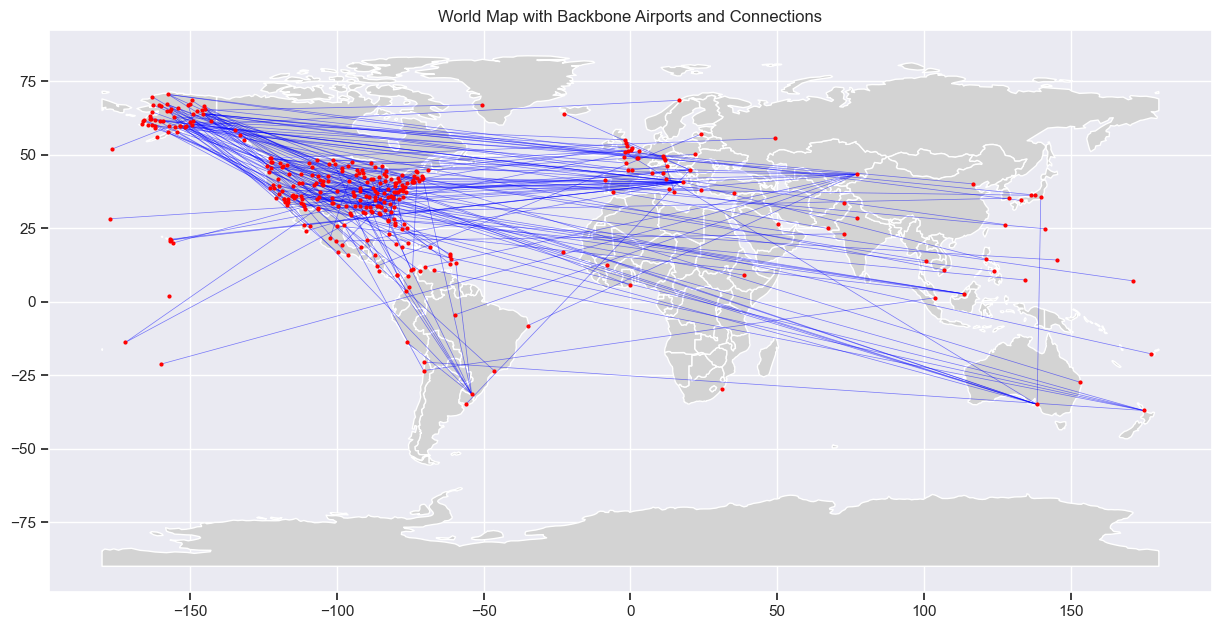

In [35]:
# Plot the world map
fig, ax = plt.subplots(figsize=(15, 10))
world.plot(ax=ax, color='lightgrey')

# Plot the edges between the airports
for edge in B.edges():
    lon1, lat1 = G.nodes[edge[0]]['lon'], G.nodes[edge[0]]['lat']
    lon2, lat2 = G.nodes[edge[1]]['lon'], G.nodes[edge[1]]['lat']
    plt.plot([lon1, lon2], [lat1, lat2], color='blue', alpha=0.5, linewidth=0.5)

# Plot the airports on the map
for node in B.nodes():
    lon, lat = G.nodes[node]['lon'], G.nodes[node]['lat']
    plt.plot(lon, lat, marker='o', color='red', markersize=2)  # 60% smaller

plt.title('World Map with Backbone Airports and Connections')
plt.show()


Visualization of only US domestic flights

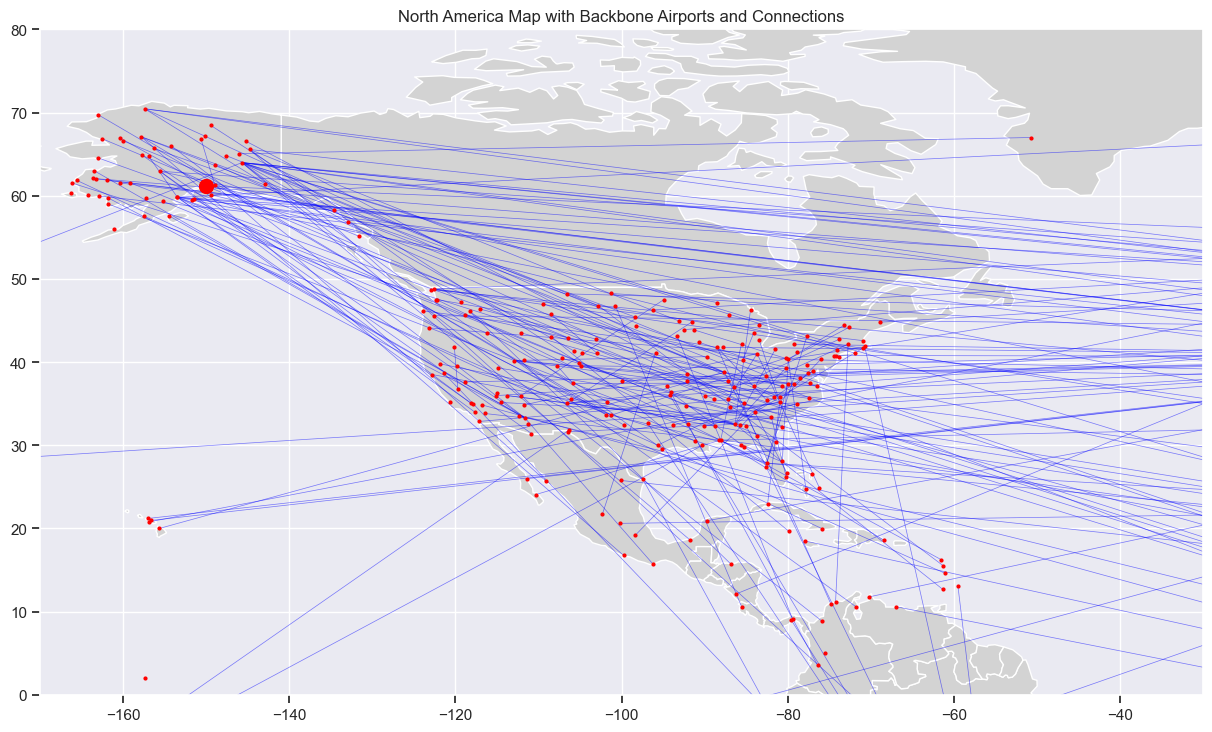

In [41]:
# Plot the world map focusing on North America
fig, ax = plt.subplots(figsize=(15, 10))
world.plot(ax=ax, color='lightgrey')

# Set axis limits to focus on North America
ax.set_xlim(-170, -30)
ax.set_ylim(0, 80)

# Plot the edges between the airports
for edge in B.edges():
    lon1, lat1 = G.nodes[edge[0]]['lon'], G.nodes[edge[0]]['lat']
    lon2, lat2 = G.nodes[edge[1]]['lon'], G.nodes[edge[1]]['lat']
    plt.plot([lon1, lon2], [lat1, lat2], color='blue', alpha=0.5, linewidth=0.5)

# Plot the airports on the map
for node in B.nodes():
    lon, lat = G.nodes[node]['lon'], G.nodes[node]['lat']
    if G.nodes[node]['code'] == 'ANC':
        plt.plot(lon, lat, marker='o', color='red', markersize=10)  # ANC with larger size
    else:
        plt.plot(lon, lat, marker='o', color='red', markersize=2)  # Other airports with smaller size

plt.title('North America Map with Backbone Airports and Connections')
plt.show()


### Robustness

#### Node attack

Robustness analysis in network science involves testing how a network responds to attacks, failures, or disruptions. There are two common types of robustness analysis:

Random Failure: In this case, nodes (or edges) are randomly removed from the network, and the effect on network properties is observed. This simulates random failures of nodes (or edges) in the network.

Targeted Attack: In this case, nodes (or edges) are removed based on certain criteria, such as highest degree, betweenness, etc. This simulates deliberate attacks on the network.

Let's perform both types of robustness analysis on the backbone network 
�
B. We will observe the effect on the size of the largest connected component as nodes are removed.

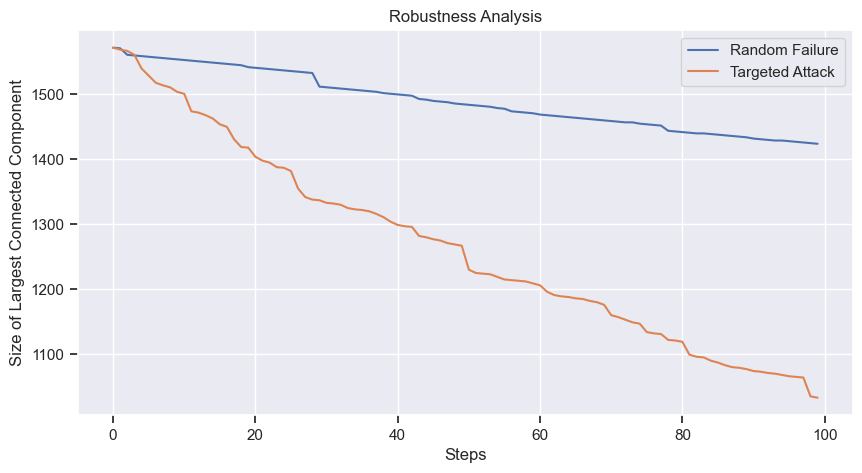

In [47]:
import networkx as nx
import matplotlib.pyplot as plt
import random

def robustness_analysis(G, attack_type='random', steps=100):
    # Copy the graph
    G_copy = G.copy()

    # List to store the size of the largest connected component at each step
    sizes = []

    for i in range(steps):
        # Calculate the largest connected component
        largest_cc = max(nx.connected_components(G_copy.to_undirected()), key=len)
        sizes.append(len(largest_cc))

        # Remove a node
        if attack_type == 'random':
            node_to_remove = random.choice(list(G_copy.nodes()))
        elif attack_type == 'targeted':
            # Find the node with the highest degree
            node_to_remove = max(dict(G_copy.degree()).items(), key=lambda x: x[1])[0]
        else:
            raise ValueError("Invalid attack_type. Must be 'random' or 'targeted'.")
        
        # Remove the node and its associated edges
        G_copy.remove_node(node_to_remove)

    return sizes

# Perform robustness analysis for random failure
random_failure_sizes = robustness_analysis(G, attack_type='random', steps=100)

# Perform robustness analysis for targeted attack
targeted_attack_sizes = robustness_analysis(G, attack_type='targeted', steps=100)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(random_failure_sizes, label='Random Failure')
plt.plot(targeted_attack_sizes, label='Targeted Attack')
plt.xlabel('Steps')
plt.ylabel('Size of Largest Connected Component')
plt.title('Robustness Analysis')
plt.legend()
plt.show()

To find the top 10 nodes whose removal would have the greatest impact on the network, we can measure the impact by the change in the size of the largest connected component after the node is removed. Here's how we can do it:

    For each node in the network:
        Remove the node and its associated edges.
        Calculate the size of the largest connected component.
        Record the difference in size of the largest connected component before and after the removal.
    Sort the nodes by the recorded difference in descending order.
    Return the top 10 nodes.

In [48]:
def top_impact_nodes(G, top_n=10):
    """
    Identify the top N nodes whose removal has the greatest impact on the network.

    Parameters:
        G: networkx graph
        top_n: number of nodes to return

    Returns:
        top_nodes: list of top N nodes with greatest impact
    """
    # Copy the graph
    G_copy = G.copy()

    # Calculate the size of the largest connected component before any removal
    initial_lcc = len(max(nx.connected_components(G_copy.to_undirected()), key=len))

    # Dictionary to store the impact of each node
    impact_dict = {}

    for node in G_copy.nodes():
        # Remove the node and its associated edges
        G_temp = G_copy.copy()
        G_temp.remove_node(node)

        # Calculate the size of the largest connected component after removal
        lcc_after_removal = len(max(nx.connected_components(G_temp.to_undirected()), key=len))

        # Calculate the impact
        impact = initial_lcc - lcc_after_removal
        impact_dict[node] = impact

    # Sort the nodes by impact
    top_nodes = sorted(impact_dict.items(), key=lambda x: x[1], reverse=True)[:top_n]

    # Format the results
    top_nodes = [(get_airport_info(node), impact) for node, impact in top_nodes]

    return top_nodes

# Call the function to find the top 10 nodes with greatest impact
top_10_impact_nodes = top_impact_nodes(G, top_n=10)
top_10_impact_nodes


[(('A13', 'Anchorage'), 24),
 (('BSZ', None), 19),
 (('CLT', 'Charlotte'), 15),
 (('08A', 'Wetumpka'), 14),
 (('ALA', 'Almaty'), 13),
 (('BAD', 'Bossier City'), 11),
 (('A72', 'Chinitna Bay'), 10),
 (('BGX', 'Bage'), 10),
 (('DPG', 'Dugway Proving Ground'), 10),
 (('LZU', 'Lawrenceville'), 10)]

The value 4 associated with ('BDS', 'Brindisi') indicates the change in the size of the largest connected component after removing the node 'BDS' (Brindisi Airport) from the network. Specifically, it means that the size of the largest connected component decreased by 4 when the 'BDS' node and its associated edges were removed from the network. This is a measure of the impact that the node has on the connectivity of the network. A larger decrease in the size of the largest connected component indicates a greater impact on the network's connectivity.

#### Edge attack

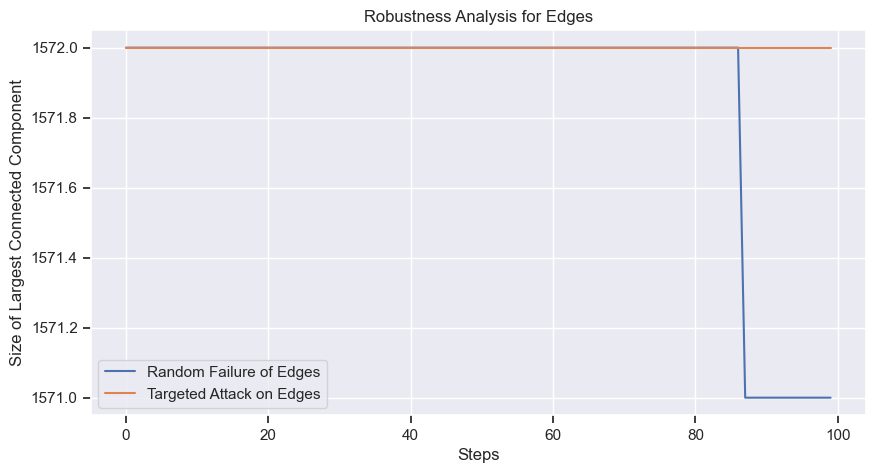

In [49]:
def robustness_analysis_edges(G, attack_type='random', steps=100):
    # Copy the graph
    G_copy = G.copy()

    # List to store the size of the largest connected component at each step
    sizes = []

    for i in range(steps):
        # Calculate the largest connected component
        largest_cc = max(nx.connected_components(G_copy.to_undirected()), key=len)
        sizes.append(len(largest_cc))

        # Remove an edge
        if attack_type == 'random':
            edge_to_remove = random.choice(list(G_copy.edges()))
        elif attack_type == 'targeted':
            # Find the edge with the highest weight
            edge_to_remove = max(nx.get_edge_attributes(G_copy, 'weight').items(), key=lambda x: x[1])[0]
        else:
            raise ValueError("Invalid attack_type. Must be 'random' or 'targeted'.")
        
        # Remove the edge
        G_copy.remove_edge(*edge_to_remove)

    return sizes

# Perform robustness analysis for random failure of edges
random_failure_sizes_edges = robustness_analysis_edges(G, attack_type='random', steps=100)

# Perform robustness analysis for targeted attack on edges
targeted_attack_sizes_edges = robustness_analysis_edges(G, attack_type='targeted', steps=100)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(random_failure_sizes_edges, label='Random Failure of Edges')
plt.plot(targeted_attack_sizes_edges, label='Targeted Attack on Edges')
plt.xlabel('Steps')
plt.ylabel('Size of Largest Connected Component')
plt.title('Robustness Analysis for Edges')
plt.legend()
plt.show()


In [50]:
def top_impact_edges(G, top_n=10):
    """
    Identify the top N edges whose removal has the greatest impact on the network.

    Parameters:
        G: networkx graph
        top_n: number of edges to return

    Returns:
        top_edges: list of top N edges with greatest impact
    """
    # Copy the graph
    G_copy = G.copy()

    # Calculate the size of the largest connected component before any removal
    initial_lcc = len(max(nx.connected_components(G_copy.to_undirected()), key=len))

    # Dictionary to store the impact of each edge
    impact_dict = {}

    for edge in G_copy.edges():
        # Remove the edge
        G_temp = G_copy.copy()
        G_temp.remove_edge(*edge)

        # Calculate the size of the largest connected component after removal
        lcc_after_removal = len(max(nx.connected_components(G_temp.to_undirected()), key=len))

        # Calculate the impact
        impact = initial_lcc - lcc_after_removal
        impact_dict[edge] = impact

    # Sort the edges by impact
    top_edges = sorted(impact_dict.items(), key=lambda x: x[1], reverse=True)[:top_n]

    # Format the results
    top_edges = [(get_airport_info(edge[0]), get_airport_info(edge[1]), impact) for edge, impact in top_edges]

    return top_edges

# Call the function to find the top 10 edges with greatest impact
top_10_impact_edges = top_impact_edges(G, top_n=10)
top_10_impact_edges


### Community Discovery


Community discovery, also known as community detection, involves identifying groups of nodes in a network that are more densely connected to each other than to the rest of the network. These groups, or communities, often represent entities or structures that share common properties or play similar roles within the network.

For the airport network, communities could represent groups of airports that are more closely connected due to geographical proximity, similar airline traffic, or other common factors.

To perform community detection, we can use algorithms such as the Louvain method, which is a popular and efficient algorithm for this purpose.

The discovered communities can be used to:

Understand the Structure of the Network: By identifying communities, we can gain insights into the overall structure and organization of the network.

Identify Important Nodes: Nodes that connect different communities can be important for the flow of information or resources within the network.

Predict Missing Links: Communities can help predict missing links in the network by assuming that nodes within the same community are more likely to be connected.

Improve Visualization: Community detection can improve the visualization of large networks by grouping together nodes that are more closely related.

In [ ]:
import networkx.algorithms.community as nx_comm

# Compute communities using the Girvan-Newman method
communities_generator = nx_comm.girvan_newman(G)
top_level_communities = next(communities_generator)
next_level_communities = next(communities_generator)
sorted_communities = sorted(map(sorted, next_level_communities))

# Draw the graph with communities
fig, ax = plt.subplots(figsize=(10, 8))
pos = nx.spring_layout(G)
colors = cm.rainbow(np.linspace(0, 1, len(sorted_communities)))
for comm, color in zip(sorted_communities, colors):
    nx.draw_networkx_nodes(G, pos, comm, node_size=40, node_color=color)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.title('Network with Girvan-Newman Communities')
plt.show()

# Count the number of nodes in each community
community_sizes = [len(comm) for comm in sorted_communities]
sorted_community_sizes = sorted(community_sizes, reverse=True)
sorted_community_sizes
